In [236]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


import category_encoders as ce # библиотека для кодирования признаков

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [237]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [238]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# 1. Загрузка данных и знакомство с ними

In [239]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [240]:
df_train.info() # общая информация о таблице train

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

В данной таблице содержатся 386803 строк, 17 столбцов (8 столбцов формата 'object', 9 - числового формата ('float64','int64'). В столбцах 'lat' и 'lng' имеются пропуски. 

In [241]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [242]:
df_test.info() # общая информация о таблице test

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

В данной таблице содержатся 128935 строк, 16 столбцов (8 столбцов формата 'object', 8 - числового формата ('float64','int64'). В столбцах 'lat' и 'lng' имеются пропуски.
нет столбца "reviewer_score", как в таблице train

In [243]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [244]:
sample_submission.head(10)

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
5,10,302161
6,10,317079
7,1,13963
8,4,159785
9,10,195089


In [245]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


# 2. Подготовка данных таблицы 'df_train'

In [246]:
display(df_train.describe())

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng
count,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.00000,386803.000000,384355.000000,384355.000000
mean,498.246536,8.397231,18.538988,2743.992042,17.776985,7.17725,8.396906,49.443522,2.823402
std,500.258012,0.547881,29.703369,2316.457018,21.726141,11.05442,1.636090,3.466936,4.579043
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.00000,2.500000,41.328376,-0.369758
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.00000,7.500000,48.214662,-0.143649
50%,342.000000,8.400000,9.000000,2134.000000,11.000000,3.00000,8.800000,51.499981,-0.000250
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.00000,9.600000,51.516288,4.834443
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.00000,10.000000,52.400181,16.429233


При изучении статических данных числового формата было выявлено:
    есть аномальные значения в столбцах 'additional_number_of_scoring', 'total_number_of_reviews', 'total_number_of_reviews_reviewer_has_given', 'average_score', 'review_total_negative_word_counts', 'review_total_positive_word_counts'

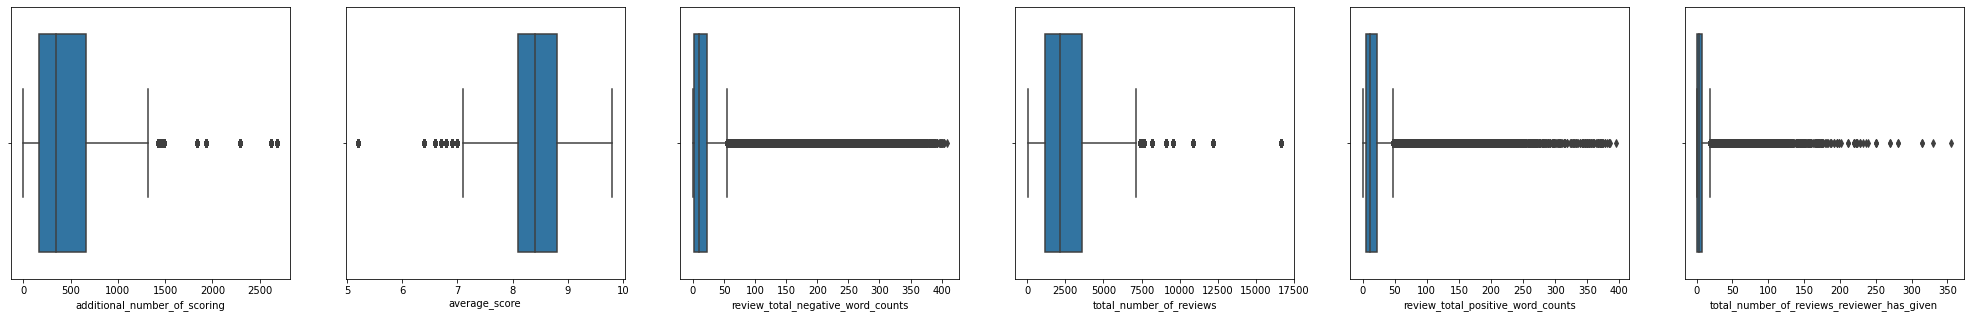

In [247]:
# Визуализируем столбцы с выбросами
fig, (ax1) = plt.subplots(nrows=1, ncols=6, figsize=(35, 5))

sns.boxplot(
    data=df_train, 
    x='additional_number_of_scoring', 
    ax=ax1[0]
);

sns.boxplot(
    data=df_train, 
    x='average_score', 
    ax=ax1[1]
);

sns.boxplot(
    data=df_train, 
    x='review_total_negative_word_counts', 
    ax=ax1[2]
);

sns.boxplot(
    data=df_train, 
    x='total_number_of_reviews', 
    ax=ax1[3]
);

sns.boxplot(
    data=df_train, 
    x='review_total_positive_word_counts', 
    ax=ax1[4]
);

sns.boxplot(
    data=df_train, 
    x='total_number_of_reviews_reviewer_has_given', 
    ax=ax1[5]
);

In [248]:
display(df_train.describe(include=['object']))

,hotel_address,review_date,hotel_name,reviewer_nationality,negative_review,positive_review,tags,days_since_review
count,386803,386803,386803,386803,386803,386803,386803,386803
unique,1493,731,1492,225,248828,311737,47135,731
top,163 Marsh Wall Docklands Tower Hamlets London ...,8/2/2017,Britannia International Hotel Canary Wharf,United Kingdom,No Negative,No Positive,"[' Leisure trip ', ' Couple ', ' Double Room '...",1 days
freq,3587,1911,3587,184033,95907,26885,3853,1911


Число уникальных значений в столбцах 'hotel_adress' и 'hotel_name'  совпадает

In [249]:
# признаки непрерывного типа
print(df_train.select_dtypes(np.number).columns.to_list())

['additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'reviewer_score', 'lat', 'lng']


In [250]:
# признаки категориального типа
print(df_train.select_dtypes('object').columns.to_list())

['hotel_address', 'review_date', 'hotel_name', 'reviewer_nationality', 'negative_review', 'positive_review', 'tags', 'days_since_review']


### 2.1 Дубликаты

In [251]:
# Найдем дубликаты в датасете
dupl_columns = list(df_train.columns) 
mask = df_train.duplicated(subset=dupl_columns)
duplicates = df_train[mask]
print(f'Число найденных дубликатов: {duplicates.shape[0]}')

df_train_dedupped = df_train.drop_duplicates(subset=dupl_columns)
print(f'Результирующее число записей: {df_train_dedupped.shape[0]}')

Число найденных дубликатов: 307
Результирующее число записей: 386496


In [252]:
# Удалим дубликаты из датасета
df_train.drop_duplicates(inplace=True, ignore_index=True)

### 2.2 Неинформативные признаки

In [253]:
#список неинформативных признаков
low_information_cols = []

#цикл по всем столбцам
for col in df_train.columns:
    #наибольшая относительная частота в признаке
    top_freq = df_train[col].value_counts(normalize=True).max()
    #доля уникальных значений от размера признака
    nunique_ratio = df_train[col].nunique() / df_train[col].count()
    # сравниваем наибольшую частоту с порогом
    if top_freq > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(top_freq*100,2)}% одинаковых значений')
    # сравниваем долю уникальных значений с порогом
    if nunique_ratio > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений')
        
info_data = df_train_dedupped.drop(low_information_cols, axis=1)
print(f'Результирующее число признаков: {info_data.shape[1]}')

Результирующее число признаков: 17


### 2.3 Пропуски

In [254]:
cols_null_percent = df_train.isnull().mean()*100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
print(cols_with_null)

lat    0.633383
lng    0.633383
dtype: float64


In [255]:
null_data = df_train[df_train.isnull().values.any(axis=1)]
null_data['hotel_name'].value_counts()

Fleming s Selection Hotel Wien City                 496
Hotel City Central                                  421
Hotel Atlanta                                       285
Maison Albar Hotel Paris Op ra Diamond              224
Hotel Daniel Vienna                                 182
Hotel Pension Baron am Schottentor                  172
Austria Trend Hotel Schloss Wilhelminenberg Wien    141
NH Collection Barcelona Podium                      113
Derag Livinghotel Kaiser Franz Joseph Vienna        112
City Hotel Deutschmeister                            63
Holiday Inn Paris Montmartre                         47
Hotel Park Villa                                     44
Cordial Theaterhotel Wien                            40
Roomz Vienna                                         34
Mercure Paris Gare Montparnasse                      28
Hotel Advance                                        26
Renaissance Barcelona Hotel                          20
Name: hotel_name, dtype: int64

Внесение координат на место пропусков

In [256]:
# Список названий отелей с пропущенными координатами
names_list = null_data['hotel_name'].unique().tolist()
names_list

['Austria Trend Hotel Schloss Wilhelminenberg Wien',
 'Holiday Inn Paris Montmartre',
 'Fleming s Selection Hotel Wien City',
 'Hotel Atlanta',
 'Maison Albar Hotel Paris Op ra Diamond',
 'Derag Livinghotel Kaiser Franz Joseph Vienna',
 'Hotel City Central',
 'NH Collection Barcelona Podium',
 'City Hotel Deutschmeister',
 'Hotel Daniel Vienna',
 'Roomz Vienna',
 'Hotel Pension Baron am Schottentor',
 'Mercure Paris Gare Montparnasse',
 'Hotel Park Villa',
 'Hotel Advance',
 'Renaissance Barcelona Hotel',
 'Cordial Theaterhotel Wien']

In [257]:
# список координат для списка с названиями отеля
coordinates = [(48.220662,16.355555), (48.22092,16.366712), (48.888887,2.333167), (48.206487,16.36346), (48.21359,16.379881),
               (48.209477,16.35135), (40.874386,0.149246), (48.188578,16.382747), (48.87526,2.323403), (48.839813,2.323573),
               (48.2167,16.359983), (48.22005,16.284974), (41.712633,0.906265), (48.245935,16.341397), (48.186409,16.42017),
               (48.233495,16.345556), (41.379389,2.157475)]

In [258]:
for name, coord in zip(names_list, coordinates):
    df_train.loc[df_train['hotel_name'] == name, ['lat', 'lng']] = coord[0], coord[1]
    
df_train[['lat', 'lng']].isnull().sum()

lat    0
lng    0
dtype: int64

In [259]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

# 3. Извлечение информации из строковых данных и создание новых признаков


## 3.1 Работа с датами

In [260]:
# Преобразуем дату в формат datetime
data['review_date'] = pd.to_datetime(data['review_date'])


# Посмотрим даты первого и последнего отзывов
data_min = data['review_date'].min()
data_max = data['review_date'].max()
print(f'Последний отзыв оставлен {data_max}. Первый отзыв оставлен {data_min}.')

# Извлечем из даты возраст отзыва, год, месяц и день недели
data['review_age'] = (pd.to_datetime('today') - data['review_date']).dt.days
data['review_day_of_week'] = data['review_date'].dt.weekday
data['review_month'] = data['review_date'].dt.month
data['review_year'] = data['review_date'].dt.year

# закодируем год
or_code = ce.OrdinalEncoder(cols=['review_year'])
data['year_code'] = or_code.fit_transform(data[['review_year']])

# Удалим признак "даты обзора" из данных
data.drop('review_date', axis=1 , inplace=True)

data.head(2)

Последний отзыв оставлен 2017-08-03 00:00:00. Первый отзыв оставлен 2015-08-04 00:00:00.


,hotel_address,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,days_since_review,lat,lng,sample,reviewer_score,review_age,review_day_of_week,review_month,review_year,year_code
0,Via Senigallia 6 20161 Milan Italy,904,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,...,13 days,45.533137,9.171102,0,0.0,2139,4,7,2017,1
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,...,234 day,52.385649,4.834443,0,0.0,2360,0,12,2016,2


## 3.2 Работа с текстом
### 3.2.1 Анализ адресов отеля

In [261]:
# Смотрим уникальные адреса у отелей
data['hotel_address'].value_counts()

163 Marsh Wall Docklands Tower Hamlets London E14 9SJ United Kingdom              4789
372 Strand Westminster Borough London WC2R 0JJ United Kingdom                     4256
Westminster Bridge Road Lambeth London SE1 7UT United Kingdom                     4169
Scarsdale Place Kensington Kensington and Chelsea London W8 5SY United Kingdom    3578
7 Pepys Street City of London London EC3N 4AF United Kingdom                      3212
                                                                                  ... 
8 rue Fr d ric Bastiat 8th arr 75008 Paris France                                   12
2 4 Boundary Street Hackney London E2 7DD United Kingdom                            12
Via M Buonarroti 13 Fiera Milano City 20149 Milan Italy                             10
13 Rue Fran ois Ory 92120 Paris France                                              10
Johann Staud Stra e 32 16 Ottakring 1160 Vienna Austria                              8
Name: hotel_address, Length: 1493, dtype: i

In [262]:
#  Делаем функцию для создания признака "страна"
def get_country(address):
    words_list = address.strip().split(' ') # убираем пробелы в конце и в начале, разбиваем строку
    if 'United Kingdom' in address:
        return('United Kingdom')
    else:
        return(words_list[-1]) # используем индекс -1 так как в датасете страна написана в конце
    
# Используем созданную функцию на датасете
data['hotel_country'] = data['hotel_address'].apply(get_country)

# Подсчет уникальных значений
data['hotel_country'].value_counts()

United Kingdom    262300
Spain              60149
France             59626
Netherlands        57212
Austria            38938
Italy              37206
Name: hotel_country, dtype: int64

In [263]:
#  Делаем функцию для создания признака "город"
def get_city(address):
    words_list = address.split(' ') # разбиваем строку
    if 'United Kingdom' in address:
        return(words_list[-5]) # используем индекс -5 так как в United Kingdom используют индекс в адресе отеля
    else:
        return(words_list[-2]) # используем индекс -2 так как в датасете город написан перед страной

# Используем созданную функцию на датасете
data['hotel_city'] = data['hotel_address'].apply(get_city)

# Подсчет уникальных значений
data['hotel_city'].value_counts()

London       262300
Barcelona     60149
Paris         59626
Amsterdam     57212
Vienna        38938
Milan         37206
Name: hotel_city, dtype: int64

In [264]:
# Проверяем все ли строки заполнены в признаке "страна"
data_country = data['hotel_country'].value_counts().sum() 
print(f'Количество строк в столбце "hotel_country" {data_country}.')

# Проверяем все ли строки заполнены в признаке "город"
data_city = data['hotel_city'].value_counts().sum()
print(f'Количество строк в столбце "hotel_city" {data_city}.')

Количество строк в столбце "hotel_country" 515431.
Количество строк в столбце "hotel_city" 515431.


Итог: наблюдаем равное количество строк в столбцах 'hotel_city' и 'hotel_country'. Соответственно можно удалить один из столбцов во избежания дублирования информации. 

In [265]:
# Удаляем столбец с городами
data.drop('hotel_city', axis=1 , inplace=True)

# Удаляем столбец с адресом отелей
data.drop('hotel_address', axis=1 , inplace=True)

In [266]:
# закодиируем столбец со странами
encoder = ce.OneHotEncoder(cols=['hotel_country'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data['hotel_country'])
data = pd.concat([data, type_bin], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 28 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   average_score                               515431 non-null  float64
 2   hotel_name                                  515431 non-null  object 
 3   reviewer_nationality                        515431 non-null  object 
 4   negative_review                             515431 non-null  object 
 5   review_total_negative_word_counts           515431 non-null  int64  
 6   total_number_of_reviews                     515431 non-null  int64  
 7   positive_review                             515431 non-null  object 
 8   review_total_positive_word_counts           515431 non-null  int64  
 9   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 

In [267]:
# Преобразуем столбец с днями проверки отзывов
data['days_since_review'] = data['days_since_review'].apply(lambda x: x.split()[0]).astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 28 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   average_score                               515431 non-null  float64
 2   hotel_name                                  515431 non-null  object 
 3   reviewer_nationality                        515431 non-null  object 
 4   negative_review                             515431 non-null  object 
 5   review_total_negative_word_counts           515431 non-null  int64  
 6   total_number_of_reviews                     515431 non-null  int64  
 7   positive_review                             515431 non-null  object 
 8   review_total_positive_word_counts           515431 non-null  int64  
 9   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 

### 3.2.2 Анализ национальности рецензентов

In [268]:
#Смотрим количество стран из которых были люди оставившие отзыв
nationality = data['reviewer_nationality'].nunique()
print(f'Количество стран из которых были люди оставившие отзыв: {nationality}.')

Количество стран из которых были люди оставившие отзыв: 227.


In [269]:
# Создаем функцию, которая убирает пробелы в конце и в начале
def function_city(nation):
    nation = nation.strip()
    return nation 

# Применяем функцию удаляющую пробелы в конце и в начале
data['reviewer_nationality'] = data['reviewer_nationality'].apply(function_city)

# Создаем признак, отображающие есть ли люди путешествующие внутри своей страны
data['domestic_trip'] = data['reviewer_nationality'] == data['hotel_country']

# Проверяем наличие людей путешествующих внутри и за пределами своей страны
data['domestic_trip'].value_counts()

False    337047
True     178384
Name: domestic_trip, dtype: int64

In [270]:
# Кодируем названия отелей и национальность ревьюера посредсвом бинарного кодирования
bincode = ce.BinaryEncoder(cols=['hotel_name', 'reviewer_nationality'])
n_n_code = bincode.fit_transform(data[['hotel_name', 'reviewer_nationality']])
data = pd.concat([data, n_n_code], axis=1)

In [271]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 48 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   average_score                               515431 non-null  float64
 2   hotel_name                                  515431 non-null  object 
 3   reviewer_nationality                        515431 non-null  object 
 4   negative_review                             515431 non-null  object 
 5   review_total_negative_word_counts           515431 non-null  int64  
 6   total_number_of_reviews                     515431 non-null  int64  
 7   positive_review                             515431 non-null  object 
 8   review_total_positive_word_counts           515431 non-null  int64  
 9   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 

### 3.2.3 Анализ положительных и отрицательных отзывов

In [272]:
# Создадим функцию, которая приведет отзывы к нижнему регистру и уберём пробелы в конце и в начале
def get_lower_strip(review):
    review = review.lower().strip()
    return review

# Применяем созданную функцию 
data['negative_review'] = data['negative_review'].apply(get_lower_strip)
data['positive_review'] = data['positive_review'].apply(get_lower_strip)

In [273]:
# Посмотрим какие есть уникальные отрицательные отзывы
negative = data['negative_review'].value_counts()
print(negative[0:50])

# Посмотрим какие есть уникальные положительные отзывы
positive = data['positive_review'].value_counts()
print(positive[0:50])

no negative                       127816
nothing                            21177
n a                                 1815
none                                1501
                                     849
nothing really                       655
small room                           570
breakfast                            545
all good                             544
no complaints                        523
location                             501
nothing at all                       466
everything                           419
nothing to dislike                   373
price                                348
nil                                  332
small rooms                          307
everything was perfect               276
na                                   272
can t think of anything              250
leaving                              244
absolutely nothing                   242
everything was great                 222
expensive                            206
nothing to compl

#### 3.2.3.1 Признаки, связанные с номером

In [274]:
# Создадим признак "проблема с номером"
data['room_bad'] = data['negative_review'].apply(lambda x: 1 if 'room' in x else 0) 
room_bad = data['room_bad'].value_counts() # проверяем работу lambda-функции
print(room_bad)

# Создадим признак "хорошая комната"
data['room_good'] = data['positive_review'].apply(lambda x: 1 if 'room' in x else 0)
room_good = data['room_good'].value_counts() # проверяем работу lambda-функции
print(room_good)


# Создадим признак "хорошая кровать"
data['bed_good'] = data['positive_review'].apply(lambda x: 1 if 'bed' in x else 0) 
bed_good = data['bed_good'].value_counts() # проверяем работу lambda-функции
print(bed_good)

# Создадим признак "проблема с кроватью"
data['bed_bad'] = data['negative_review'].apply(lambda x: 1 if ('bed' in x) or ('beds' in x) else 0) 
bed_bad = data['bed_bad'].value_counts() # проверяем работу lambda-функции
print(bed_bad)

0    357177
1    158254
Name: room_bad, dtype: int64
0    353011
1    162420
Name: room_good, dtype: int64
0    448525
1     66906
Name: bed_good, dtype: int64
0    478294
1     37137
Name: bed_bad, dtype: int64


#### 3.2.3.2 Признак - клининг комнаты

In [275]:
data['cleaning_bad'] = data['negative_review'].apply(lambda x: 1 if ('cleaning' in x) or ('clean' in x) or ('dirt' in x) else 0) 
cleaning_bad = data['cleaning_bad'].value_counts() # проверяем работу lambda-функции
print(cleaning_bad)

data['cleaning_good'] = data['positive_review'].apply(lambda x: 1 if ('cleaning' in x) or ('clean' in x) or ('dirt' in x) else 0)  
cleaning_good = data['cleaning_good'].value_counts() # проверяем работу lambda-функции
print(cleaning_good)

0    493333
1     22098
Name: cleaning_bad, dtype: int64
0    441018
1     74413
Name: cleaning_good, dtype: int64


#### 3.2.3.3 Признак - wi-fi

In [276]:
# Создадим признак "проблема с wifi"
data['wifi_bad'] = data['negative_review'].apply(lambda x: 1 if ('wi-fi' in x) or ('internet' in x) or ('wi fi' in x) or ('wifi' in x) else 0) 
wifi_bad = data['wifi_bad'].value_counts() # проверяем работу lambda-функции
print(wifi_bad)

# Создадим признак "хорошая wi-fi"
data['wifi_good'] = data['positive_review'].apply(lambda x: 1 if ('wi-fi' in x) or ('internet' in x) or ('wi fi' in x) or ('wifi' in x) else 0) 
wifi_good = data['wifi_good'].value_counts() # проверяем работу lambda-функции
print(wifi_good)

0    498370
1     17061
Name: wifi_bad, dtype: int64
0    505386
1     10045
Name: wifi_good, dtype: int64


#### 3.2.3.4 Признаки свзянные с персоналом

In [277]:
# Создадим признак "проблема с работниками"
data['staff_bad'] = data['negative_review'].apply(lambda x: 1 if 'staff' in x else 0) 
staff_bad = data['staff_bad'].value_counts() # проверяем работу lambda-функции
print(staff_bad)

# Создадим признак "хороший персонал"
data['staff_good'] = data['positive_review'].apply(lambda x: 1 if 'staff' in x else 0)
staff_good = data['staff_good'].value_counts() # проверяем работу lambda-функции
print(staff_good)

0    480525
1     34906
Name: staff_bad, dtype: int64
0    326052
1    189379
Name: staff_good, dtype: int64


#### 3.2.3.5 Признаки, связанные с качеством питания


In [278]:
data['meal_service_bad'] = data['negative_review'].apply(lambda x: 1 if ('breakfast' in x) or ('eat' in x) or ('dinner' in x) or ('lunch' in x) or ('meal' in x) else 0)
meal_service_bad = data['meal_service_bad'].value_counts() # проверяем работу lambda-функции
print(meal_service_bad)

data['meal_service_good'] = data['positive_review'].apply(lambda x: 1 if ('breakfast' in x) or ('eat' in x) or ('dinner' in x) or ('lunch' in x) else 0)
meal_service_good = data['meal_service_good'].value_counts() # проверяем работу lambda-функции
print(meal_service_good)

0    443224
1     72207
Name: meal_service_bad, dtype: int64
0    353352
1    162079
Name: meal_service_good, dtype: int64


#### 3.2.3.6 Признаки, связанные с местоположением отеля

In [279]:
# Создадим признак 
data['location_bad'] = data['negative_review'].apply(lambda x: 1 if ('location' in x) or ('place' in x) else 0) 
location_bad = data['location_bad'].value_counts() # проверяем работу lambda-функции
print(location_bad)
# Создадим признак "хорошая локация"
data['location_good'] = data['positive_review'].apply(lambda x: 1 if ('location' in x) or ('place' in x) else 0) 
location_good = data['location_good'].value_counts() # проверяем работу lambda-функции
print(location_good)

0    495389
1     20042
Name: location_bad, dtype: int64
0    316648
1    198783
Name: location_good, dtype: int64


#### 3.2.3.7 Признак - свежесть отеля 

In [280]:
# Создадим признак "старое"
data['old'] = data['negative_review'].apply(lambda x: 1 if 'old' in x else 0) 
old = data['old'].value_counts() # проверяем работу lambda-функции
print(old)

# Создадим признак "новое"
data['new'] = data['positive_review'].apply(lambda x: 1 if 'new' in x else 0)  
new = data['new'].value_counts() # проверяем работу lambda-функции
print(new)

0    486395
1     29036
Name: old, dtype: int64
0    508327
1      7104
Name: new, dtype: int64


#### 3.2.3.8 Признаки, связанные с ценообразованием

In [281]:
# Создадим признак "проблема с ценой"
data['price_bad'] = data['negative_review'].apply(lambda x: 1 if ('price' in x) or ('expensive' in x) or ('cost' in x) else 0)
price_bad = data['price_bad'].value_counts() # проверяем работу lambda-функции
print(price_bad)

# Создадим признак "хорошая цена"
data['price_good'] = data['positive_review'].apply(lambda x: 1 if ('price' in x) or ('cheap' in x) or ('cost' in x) else 0)
price_good = data['price_good'].value_counts() # проверяем работу lambda-функции
print(price_good)

0    475174
1     40257
Name: price_bad, dtype: int64
0    501450
1     13981
Name: price_good, dtype: int64


#### 3.2.3.9 Признак - общее впечатление

In [282]:
# Создадим признак "все не понравилось"
data['negative_all'] = data['negative_review'].apply(lambda x: 1 if ('all' in x) or ('everything' in x) else 0) 
negative_all = data['negative_all'].value_counts() # проверяем работу lambda-функции
print(negative_all)

# Создадим признак "все понравилось"
data['positive_all'] = data['positive_review'].apply(lambda x: 1 if ('all' in x) or ('everything' in x) else 0) 
positive_all = data['positive_all'].value_counts() # проверяем работу lambda-функции
print(positive_all)

0    402690
1    112741
Name: negative_all, dtype: int64
0    412248
1    103183
Name: positive_all, dtype: int64


In [283]:
# Создаём списки с отсутствием позитивных и отсутствием негативных отзывов
no_negative_list = ['no negative', 'nothing', 'n a', 'none', ' ', 'nothing really', 
               'no complaints', 'nothing at all', 'nothing to dislike','nil', 
               'na', 'everything was perfect', 'everything was great', 
               'nothing to complain about', 'i liked everything',
               'liked everything', 'everything was good', 'nothing everything was great',
              'non', 'everything was fine']

no_positive_list = ['no positive', 'nothing','nothing ', ' ']


# Сигнальные признаки отсутсвия негативных и отсутвия позитивных отзывов
data['negative'] = data['negative_review'].apply(lambda x: 0 if x in no_negative_list else 1)
data['positive'] = data['positive_review'].apply(lambda x: 0 if x in no_positive_list else 1)

### 3.2.4 Признаки тэга

In [284]:
# Создадим функцию, которая разбивает строку
def rev_tags(number_tags):
    number_tags = number_tags[2:-2] # указываем 2 и -2 чтобы исключить для дальнейшей работы скобки и пробел
    list_tags = number_tags.split(" ', '") # разбивает строку
    return list_tags

# Создадим отдельный признак со списками тегов
data['tags_list'] = data['tags'].apply(rev_tags)

# Создадим переменную, где каждый тег взят по отдельности
data_tag = data.explode('tags_list') 

# Смотрим количество уникальных тегов
data_tag['tags_list'].value_counts()[0:50]

 Leisure trip                       417538
 Submitted from a mobile device     307470
 Couple                             252090
 Stayed 1 night                     117408
 Solo traveler                      108459
 Business trip                       82884
 Stayed 2 nights                     79783
 Stayed 1 night                      76160
 Group                               65344
 Family with young children          60979
 Stayed 3 nights                     56589
 Stayed 2 nights                     54067
 Stayed 3 nights                     39172
 Double Room                         35207
 Standard Double Room                32247
 Superior Double Room                31361
 Stayed 4 nights                     27734
 Family with older children          26329
 Deluxe Double Room                  24812
 Double or Twin Room                 22393
 Stayed 4 nights                     20043
 Standard Double or Twin Room        17479
 Classic Double Room                 16877
 Superior D

#### 3.2.4.1 Признак - количество ночей

In [285]:
# cоздадим признак количество ночей, если количество не указано, то поставим 0 ночей и преобразуем данные в числа
data['stayed_nights'] = data['tags'].str.extract(r'Stayed (\d+) night').fillna(0).astype(int)
data['stayed_nights'].value_counts() # проверяем результат

1     193568
2     133850
3      95761
4      47777
5      20826
6       9765
7       7391
8       2499
9       1293
10       888
11       417
12       316
14       247
13       246
0        192
15       117
16        57
17        42
18        33
19        29
21        23
20        19
27        11
30        11
23        10
22        10
25         7
26         7
28         7
24         6
29         5
31         1
Name: stayed_nights, dtype: int64

#### 3.2.4.2 Признак - кто остановился в отеле и по какой причине?

In [286]:
# Создадим признак "бизнес путешествие"
data['business_trip'] = data['tags'].apply(lambda x: 1 if 'Business trip' in x else 0) 
print(data['business_trip'].value_counts()) # проверяем результат

# Создадим признак "путешествие на отдых"
data['leisure_trip'] = data['tags'].apply(lambda x: 1 if 'Leisure trip' in x else 0) 
print(data['leisure_trip'].value_counts()) # проверяем результат


# Создадим признак "путешествие с семьей"
data['traveling_with_family'] = data['tags'].apply(lambda x: 1 if 'Family' in x else 0) 
print(data['traveling_with_family'].value_counts()) # проверяем результат


# Создадим признак "путешествие в одиночку"
data['traveling_with_alone'] = data['tags'].apply(lambda x: 1 if 'Solo' in x else 0) 
print(data['traveling_with_alone'].value_counts()) # проверяем результат


# Создадим признак "путешествие в паре"
data['traveling_with_pairs'] = data['tags'].apply(lambda x: 1 if 'Couple' in x else 0) 
print(data['traveling_with_pairs'].value_counts()) # проверяем результат

0    432547
1     82884
Name: business_trip, dtype: int64
1    417538
0     97893
Name: leisure_trip, dtype: int64
0    426073
1     89358
Name: traveling_with_family, dtype: int64
0    406955
1    108476
Name: traveling_with_alone, dtype: int64
0    263303
1    252128
Name: traveling_with_pairs, dtype: int64


#### 3.2.4.3 Признак - тип номера

In [287]:
# Создадим признак "номер комфорт"
data['сomfort_room'] = data['tags'].apply(lambda x: 1 if 'Comfort' in x else 0) 
print(data['сomfort_room'].value_counts()) # проверяем результат

# Создадим признак "номер делюкс"
data['deluxe_room'] = data['tags'].apply(lambda x: 1 if 'Deluxe' in x else 0) 
print(data['deluxe_room'].value_counts()) # проверяем результат

# Создадим признак "номер класический"
data['сlassic_room'] = data['tags'].apply(lambda x: 1 if 'Classic' in x else 0) 
print(data['сlassic_room'].value_counts()) # проверяем результат

# Создадим признак "номер стандартный"
data['standard_room'] = data['tags'].apply(lambda x: 1 if 'Standard' in x else 0) 
print(data['standard_room'].value_counts()) # проверяем результат

# Создадим признак "номер люкс"
data['luxury_room'] = data['tags'].apply(lambda x: 1 if 'Luxury' in x else 0) 
print(data['luxury_room'].value_counts()) # проверяем результат

# Создадим признак "номер двойной"
data['double_room'] = data['tags'].apply(lambda x: 1 if 'Double' in x else 0) 
print(data['double_room'].value_counts()) # проверяем результат

0    507671
1      7760
Name: сomfort_room, dtype: int64
0    449564
1     65867
Name: deluxe_room, dtype: int64
0    479594
1     35837
Name: сlassic_room, dtype: int64
0    428103
1     87328
Name: standard_room, dtype: int64
0    512497
1      2934
Name: luxury_room, dtype: int64
1    302479
0    212952
Name: double_room, dtype: int64


#### 3.2.4.4 Признак - размещение с домашними животными

In [288]:
data['with_a_pet'] = data['tags'].apply(lambda x: 1 if 'pet' in x else 0)
data['with_a_pet'].value_counts()

0    514026
1      1405
Name: with_a_pet, dtype: int64

#### 3.2.4.5 Признак - способ размещения отзыва (через телефон или компьютер)

In [289]:
data['mobile_device'] = data['tags'].apply(lambda x: 1 if  'mobile device' in x else 0)
data['mobile_device'].value_counts()

1    307470
0    207961
Name: mobile_device, dtype: int64

In [290]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 85 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   average_score                               515431 non-null  float64
 2   hotel_name                                  515431 non-null  object 
 3   reviewer_nationality                        515431 non-null  object 
 4   negative_review                             515431 non-null  object 
 5   review_total_negative_word_counts           515431 non-null  int64  
 6   total_number_of_reviews                     515431 non-null  int64  
 7   positive_review                             515431 non-null  object 
 8   review_total_positive_word_counts           515431 non-null  int64  
 9   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 

# 4 Нормализация данных

In [291]:
# Создадим список с числовыми признаками (с выбросами), которые мы хотим нормализовать
cols = [
    'review_total_negative_word_counts', 'review_total_positive_word_counts', 
    'total_number_of_reviews', 'additional_number_of_scoring', 'total_number_of_reviews_reviewer_has_given'
]

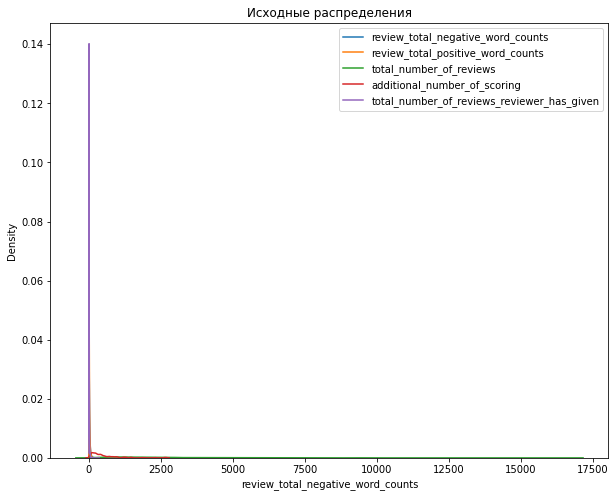

In [292]:
# зададим параметры холста, название и визуализируем кривые распределения:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Исходные распределения')

# kdeplot() (KDE – оценка плотности ядра) – специальный метод для графиков распределений
sns.kdeplot(data['review_total_negative_word_counts'], ax = ax1, label='review_total_negative_word_counts')
sns.kdeplot(data['review_total_positive_word_counts'], ax=ax1, label='review_total_positive_word_counts')
sns.kdeplot(data['total_number_of_reviews'], ax=ax1, label='total_number_of_reviews')
sns.kdeplot(data['additional_number_of_scoring'], ax=ax1, label='additional_number_of_scoring')
sns.kdeplot(data['total_number_of_reviews_reviewer_has_given'], ax = ax1, label='total_number_of_reviews_reviewer_has_given')

plt.legend()

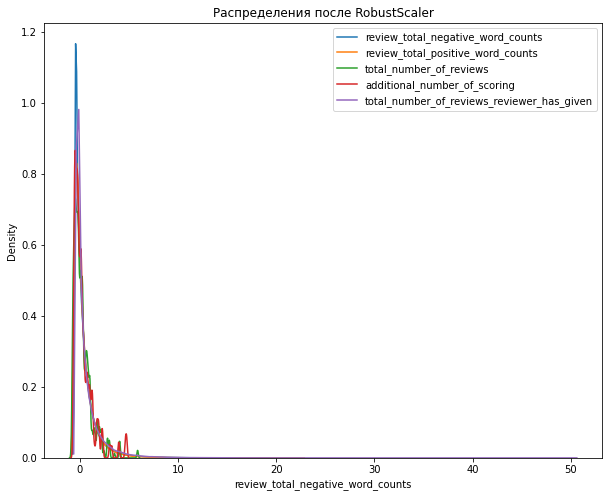

In [293]:
from sklearn import preprocessing

# Проводим нормализацию RobustScaler, так как в датасете есть выбросы
# инициализируем нормализатор RobustScaler
r_scaler = preprocessing.RobustScaler()

col_names = list(data[cols])

# кодируем исходный датасет
data[cols] = r_scaler.fit_transform(data[cols])

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
data_r = pd.DataFrame(data[cols], columns=col_names)

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Распределения после RobustScaler')

sns.kdeplot(data_r['review_total_negative_word_counts'], ax=ax1, label='review_total_negative_word_counts')
sns.kdeplot(data_r['review_total_positive_word_counts'], ax=ax1, label='review_total_positive_word_counts')
sns.kdeplot(data_r['total_number_of_reviews'], ax=ax1, label='total_number_of_reviews')
sns.kdeplot(data_r['additional_number_of_scoring'], ax=ax1, label='additional_number_of_scoring')
sns.kdeplot(data_r['total_number_of_reviews_reviewer_has_given'], ax=ax1, label='total_number_of_reviews_reviewer_has_given')

plt.legend();

In [294]:
# Колонны без выбросов
col_list = data[['days_since_review', 'review_age']].columns.tolist()

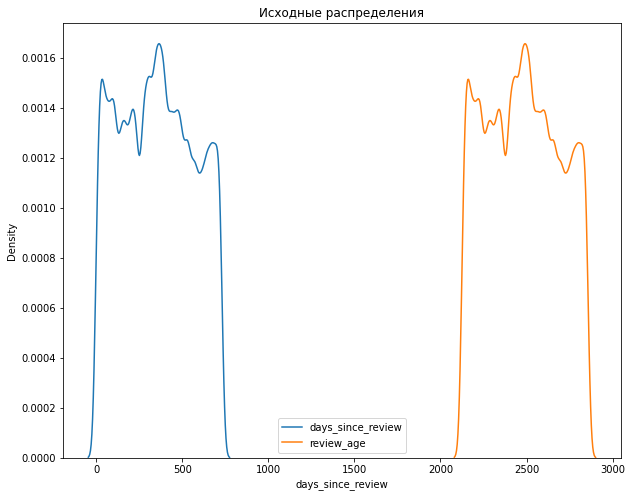

In [295]:
# зададим параметры холста, название и визуализируем кривые распределения:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Исходные распределения')

# kdeplot() (KDE – оценка плотности ядра) – специальный метод для графиков распределений
sns.kdeplot(data['days_since_review'], ax = ax1, label='days_since_review')
sns.kdeplot(data['review_age'], ax=ax1, label='review_age')

plt.legend()

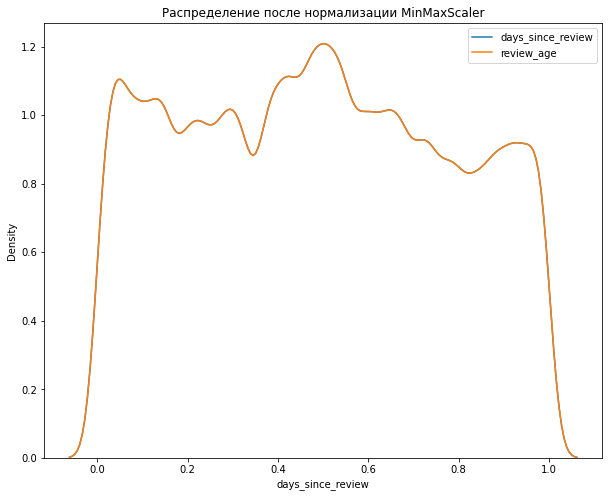

In [296]:
# инициализируем нормализатор MinMaxScaler
mm_scaler = preprocessing.MinMaxScaler()

# кодируем исходный датасет
data[col_list] = mm_scaler.fit_transform(data[col_list])

# Смотрим на распределение
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Распределение после нормализации MinMaxScaler')
for col in col_list:
       sns.kdeplot(data[col], ax=ax1, label=col)
plt.legend();


После нормализации - графики совпали, в дальнейшей работе один из столбцов будет удален, так как столбцы дублируют информацию

In [297]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 85 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  float64
 1   average_score                               515431 non-null  float64
 2   hotel_name                                  515431 non-null  object 
 3   reviewer_nationality                        515431 non-null  object 
 4   negative_review                             515431 non-null  object 
 5   review_total_negative_word_counts           515431 non-null  float64
 6   total_number_of_reviews                     515431 non-null  float64
 7   positive_review                             515431 non-null  object 
 8   review_total_positive_word_counts           515431 non-null  float64
 9   total_number_of_reviews_reviewer_has_given  515431 non-null  float64
 

# 5 Исследование данных

### Зависимость оценок пользователя от месяца и года

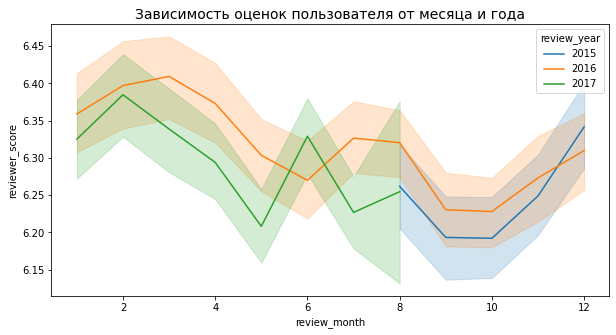

In [298]:
# Строим график зависимости оценок пользователяк от месяца и года
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))

fig = sns.lineplot(
    data = data,
    x = 'review_month',
    y = 'reviewer_score',
    hue = 'review_year',
    palette = 'tab10'
)
ax.set_title('Зависимость оценок пользователя от месяца и года', fontdict={'size': 14});


Из графика видно, что 
максимальную оценку ставят в феврале, после чего идет снижение, самые низкие оценки в мае-июне и сентябрь-октябрь.

Предполагаю, что это связано с общим количеством отзывов по месяцам. Так как летом люди чаще путешествуют, то и отзывов, в том числе и отрицательных, ставят больше.

### Зависимость количества оценок от месяца и года

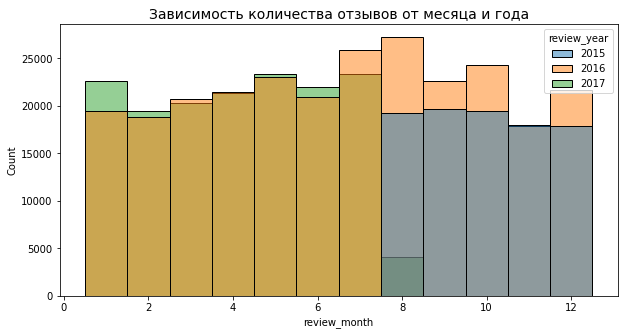

In [299]:
# Строим график зависимости количества оценок от месяца и года
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))

fig = sns.histplot(
    data = data,
    x = 'review_month',
    hue = 'review_year',
    discrete=True,
    palette = 'tab10'
)
ax.set_title('Зависимость количества отзывов от месяца и года', fontdict={'size': 14});

Из графика видно, что больше всего отзывов оставляют в июль - август, это связано с тем, что чаще всего люди предпочитают брать отпуск и путешествовать летом, когда на улице хорошая погода. Меньше оставляют отзывов в ноябре, возможно это связано с плохой погодой и приближением конца года.

###  Зависимость количества оценок от страны путешествия и от того гражданин путешествует внутри своей страны или нет

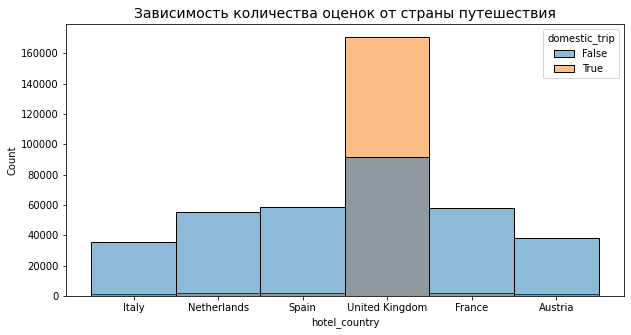

In [300]:
# Строим график зависимости количества оценок от страны путешествия и от того гражданин путешествует или нет
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))

fig = sns.histplot(
    data = data,
    x = 'hotel_country',
    hue = 'domestic_trip',
    palette = 'tab10',
    discrete=True
)
ax.set_title('Зависимость количества оценок от страны путешествия', fontdict={'size': 14});

# True - человек путешествует внутри своей страны
# False - человек приехал из другой страны

Из графика по нашем данным видно, что чаще всего путешествуют в United Kingdom, при чем в большей степени это внутренние путешествия. В других странах внутри страны очень мало путешествуют, в основном ездят за границу.

### Зависимость оценок пользователя от страны путешествия и месяца

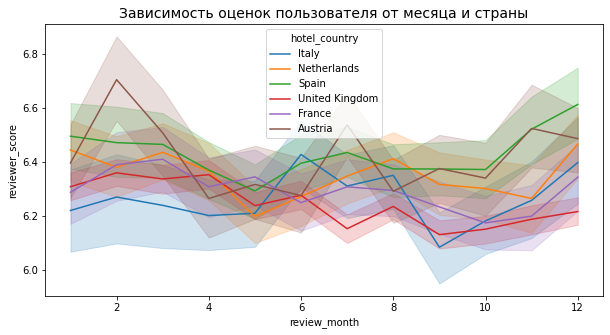

In [301]:
# Строим график зависимости оценок пользователя от страны путешествия и месяца
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))

fig = sns.lineplot(
    data = data,
    x = 'review_month',
    y = 'reviewer_score',
    hue = 'hotel_country',
    palette = 'tab10'
)
ax.set_title('Зависимость оценок пользователя от месяца и страны', fontdict={'size': 14});

На графике видно, что в целом в любой стране оценки распределена одинаково. За исключением Austria. Оценка за ее отели в феврале поднялась (может быть связана с открытиием новых отелей??). И United Kingdom имеет более низкие оценки за отели в сравнении с другими странами.


### Зависимость оценок пользователя от месяца и внутреннего путешествия

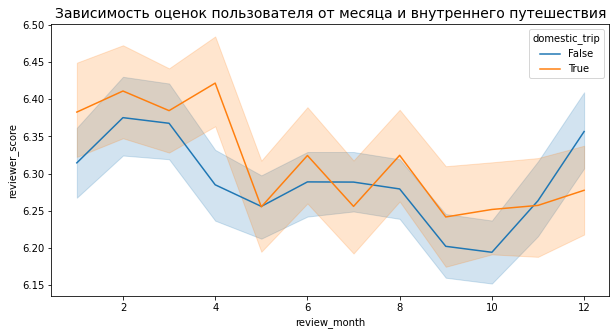

In [302]:
# Строим график зависимости оценок пользователя от страны путешествия и от того гражданин путешествует или нет
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))

fig = sns.lineplot(
    data = data,
    x = 'review_month',
    y = 'reviewer_score',
    hue = 'domestic_trip',
    palette = 'tab10'
)
ax.set_title('Зависимость оценок пользователя от месяца и внутреннего путешествия', fontdict={'size': 14});

# True - человек путешествует внутри своей страны
# False - человек приехал из другой страны

Из графика видно, что,  люди путешествующие внутри страны, ставят оценку выше, чем приехавшие.


### Зависимость количества оценок от количества ночей

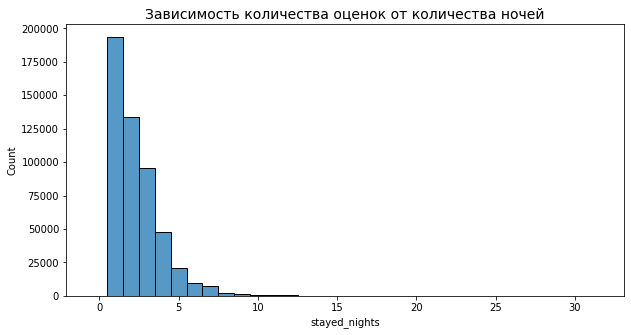

In [303]:
# Строим график зависимости количества оценок от количества ночей
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))

fig = sns.histplot(
    data = data,
    x = 'stayed_nights',
    discrete=True
)
ax.set_title('Зависимость количества оценок от количества ночей', fontdict={'size': 14});

Из графика мы видим, что больше всего оставляют отзывы люди останавливающиеся на 1 ночь. Чем больше ночей проводят люди в отеле, тем меньше оставляют отзывов. Предполагаю, что это связано с тем, что большинство людей останавливаются на несколько дней. Следовательно, отзывов они будут оставлять больше. Но почему значительно больше отзывов оставляют люди остановившиеся на 1 ночь, на данный момент сказать не могу. Нужны дальнейшее исследования данных.

### Зависимость оценок пользователя от доли положительных и отрицательных отзывов

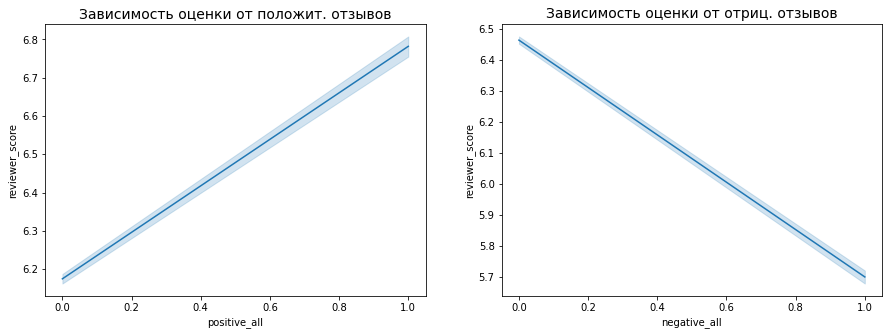

In [304]:
# Зависимость оценок пользователя от доли положительных и отрицательных отзывов
fig, (ax1) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

sns.lineplot(
    data=data, 
    x='positive_all', 
    y='reviewer_score', 
    ax=ax1[0])

sns.lineplot(
    data=data, 
    x='negative_all', 
    y='reviewer_score', 
    ax=ax1[1])

ax1[0].set_title('Зависимость оценки от положит. отзывов', fontdict={'fontsize': 14});
ax1[1].set_title('Зависимость оценки от отриц. отзывов', fontdict={'fontsize': 14});


Можем наблюдать на графиках, что отрицательные и положительные отзывы сильно влияют на оценку пользователя. Чем больше положительных отзывов, тем выше оценка, и чем больше отрицательных, тем ниже будет оценка.

#### Гипотеза

Нулевая гипотеза: нет значимой разницы между средней оценкой, которую рецензент поставил отелю и средним баллом отеля. Альтернативная гипотеза: есть значимая разница между средней оценкой, которую рецензент поставил отелю и средним баллом отеля.

Для проверки гипотезы применю тест ANOVA

In [305]:
from scipy.stats import f_oneway

reviewer = data['reviewer_score']
average = data['average_score']

alpha = 0.05
_, p = f_oneway(reviewer, average)

H0 = 'Нет значимой разницы между средней оценкой, которую рецензент поставил отелю и  средним баллом отеля'
H1 = 'Есть значимая разница между средней оценкой, которую рецензент поставил отелю и  средним баллом отеля.'

if p>alpha:
  print(f'{p} > {alpha}. Мы не можем отвергнуть нулевую гипотезу. {H0}')
else:
  print(f'{p} <= {alpha}. Мы отвергаем нулевую гипотезу. {H1}')

0.0 <= 0.05. Мы отвергаем нулевую гипотезу. Есть значимая разница между средней оценкой, которую рецензент поставил отелю и  средним баллом отеля.


# 6 Анализ и отбор признаков

In [306]:
data_copy = data.copy()

In [307]:
print(f'Текущее получившееся количество признаков: {len(data_copy.columns)}')
print('(включая целевой столбец и метку тест/трейн)')


# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']

print(f'Удалим {len(object_columns)} столбцов с нечисловыми данными')
data_copy.drop(object_columns, axis = 1, inplace=True)

Текущее получившееся количество признаков: 85
(включая целевой столбец и метку тест/трейн)
Удалим 7 столбцов с нечисловыми данными


In [308]:
# Заменим булевые значения в признаке domestic_trip на числа 0 и 1
data_copy['domestic_trip'] = data_copy['domestic_trip'].replace(True,1)
data_copy['domestic_trip'] = data_copy['domestic_trip'].replace(False,0)

In [309]:
# data_copy.columns.tolist()

## Анализ мультиколлинеарности

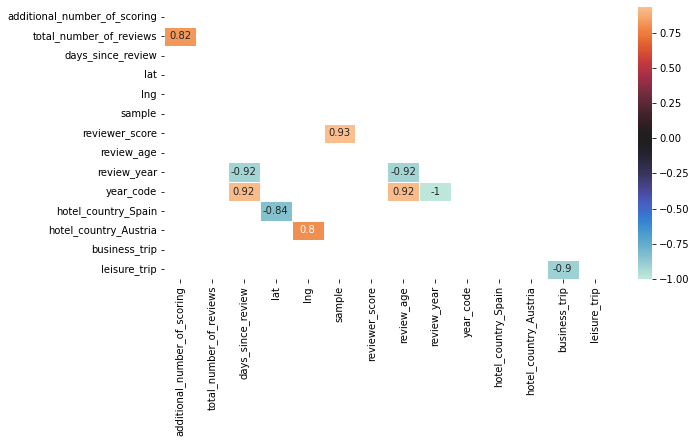

In [310]:
# Построим корреляцию и отфильтруем по очень сильной взаимосвязи
df_corr = data_copy.corr()
df_corr = df_corr[(df_corr < 1) & (abs(df_corr) > 0.7)]
df_corr = df_corr.dropna(thresh=1, axis=0)
df_corr = df_corr.dropna(thresh=1, axis=1)
matrix = np.triu(df_corr)

# Визуализируем матрицу корреляции
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.heatmap(df_corr, annot=True, ax=ax, mask=matrix, linewidths=1, center=0, vmin=-1);

In [311]:
# Удалим мультиколлинеальные признаки
data_copy = data_copy.drop([
    'additional_number_of_scoring', 'year_code', 'review_year', 'leisure_trip',
    'hotel_country_Spain', 'hotel_country_Austria', 'review_age'
], axis=1)

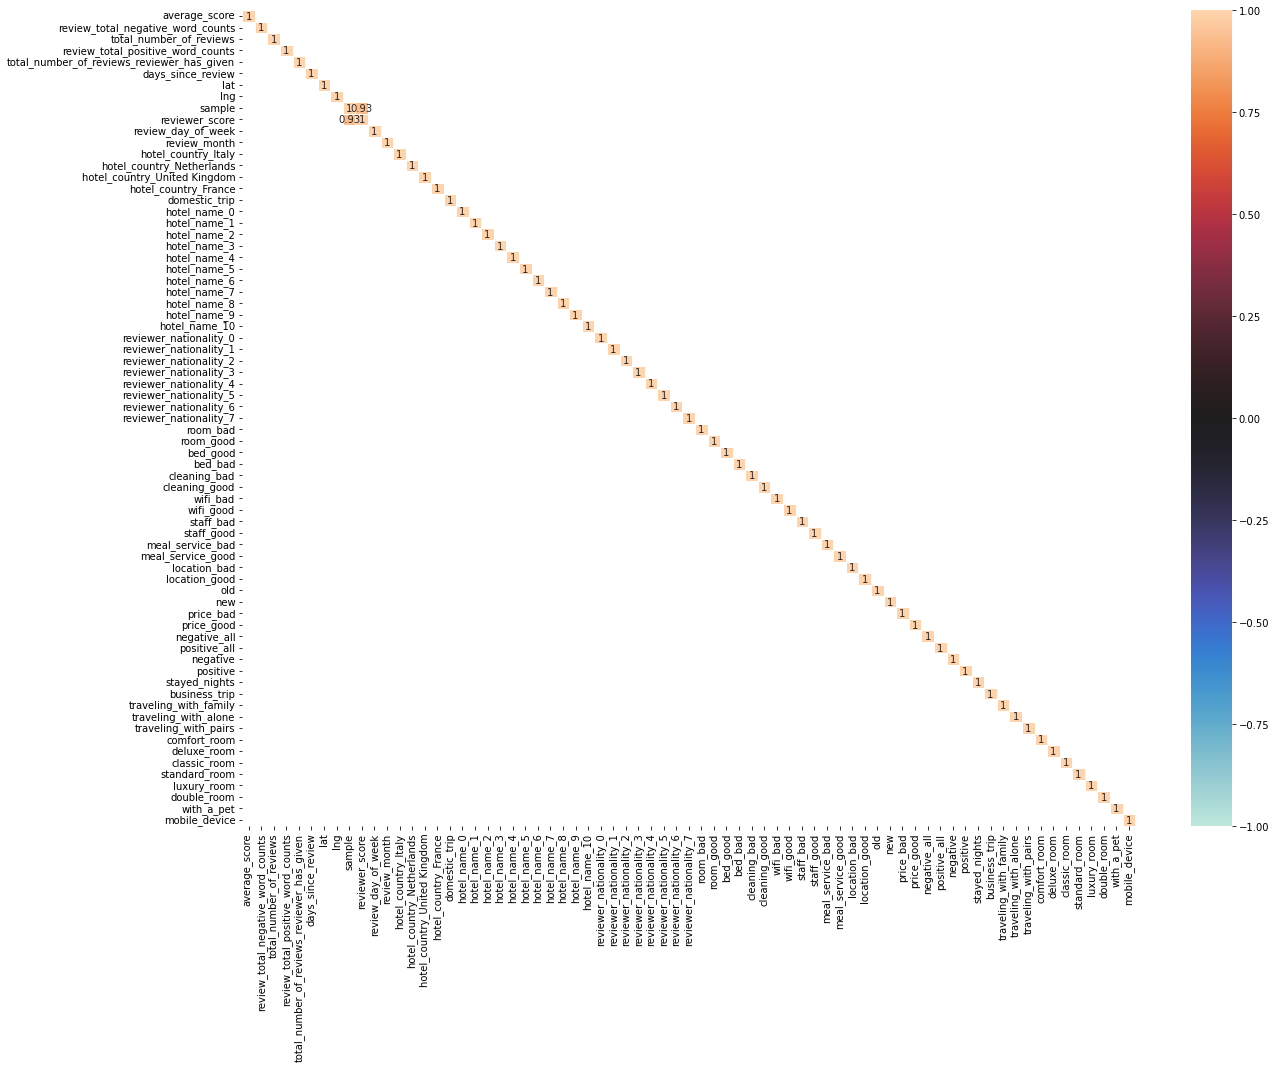

In [312]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
mask = np.array(abs(data_copy.corr()) < 0.7)
sns.heatmap(data_copy.corr(), annot=True, ax=ax, center=0, vmin=-1, linewidths=1, mask=mask);

In [313]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 71 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515431 non-null  float64
 1   review_total_negative_word_counts           515431 non-null  float64
 2   total_number_of_reviews                     515431 non-null  float64
 3   review_total_positive_word_counts           515431 non-null  float64
 4   total_number_of_reviews_reviewer_has_given  515431 non-null  float64
 5   days_since_review                           515431 non-null  float64
 6   lat                                         514611 non-null  float64
 7   lng                                         514611 non-null  float64
 8   sample                                      515431 non-null  int64  
 9   reviewer_score                              515431 non-null  float64
 

## Отбор признаков

In [314]:
# Теперь выделим тестовую часть
train_data = data_copy.query('sample == 1').drop(['sample'], axis=1)
test_data = data_copy.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

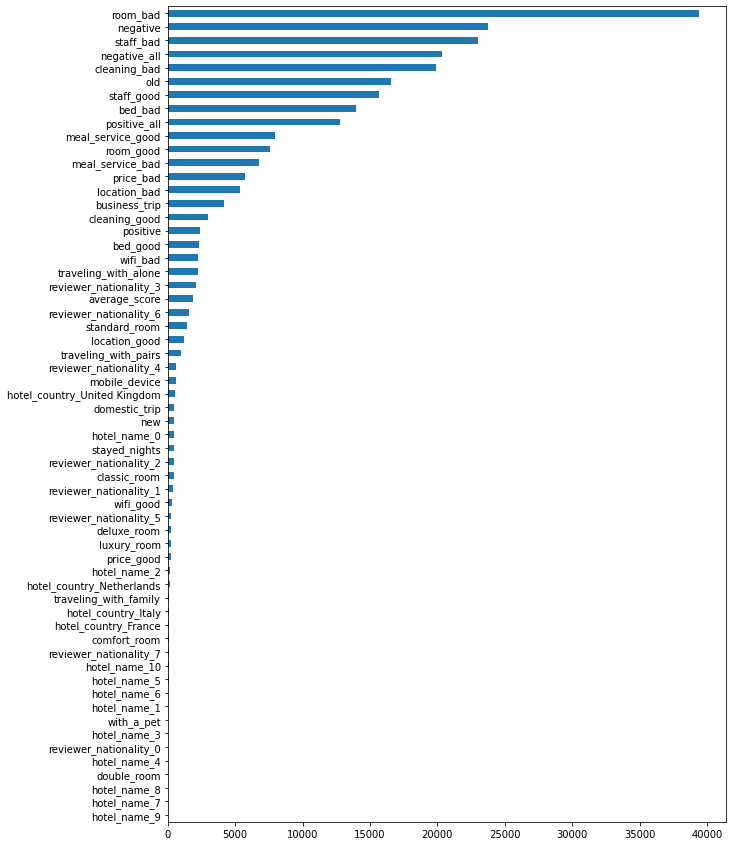

In [315]:
from sklearn.feature_selection import chi2 

# категориальные признаки
cat_cols = [
    'average_score', 'hotel_country_Italy', 'hotel_country_Netherlands',
    'hotel_country_United Kingdom', 'hotel_country_France', 
    'domestic_trip', 'hotel_name_0', 'hotel_name_1', 'hotel_name_2',
    'hotel_name_3', 'hotel_name_4', 'hotel_name_5', 'hotel_name_6',
    'hotel_name_7', 'hotel_name_8', 'hotel_name_9', 'hotel_name_10',
    'reviewer_nationality_0', 'reviewer_nationality_1', 'reviewer_nationality_2',
    'reviewer_nationality_3', 'reviewer_nationality_4', 'reviewer_nationality_5',
    'reviewer_nationality_6', 'reviewer_nationality_7', 'room_bad', 'room_good',
    'bed_good', 'bed_bad', 'cleaning_bad', 'cleaning_good', 'wifi_bad', 'wifi_good',
    'staff_bad', 'staff_good', 'meal_service_bad', 'meal_service_good', 
    'location_bad', 'location_good', 'old', 'new', 'price_bad', 'price_good',
    'negative_all','positive_all', 'negative', 'positive', 'stayed_nights', 
    'business_trip', 'traveling_with_family', 'traveling_with_alone',
    'traveling_with_pairs', 'сomfort_room', 'deluxe_room', 'сlassic_room',
    'standard_room', 'luxury_room', 'double_room', 'with_a_pet', 'mobile_device'
]

y = y.astype('int')
# Проанализируем важность категориальных признаков
imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh', figsize = (10,15));

In [316]:
# Уберем малозначимые признаки
data_copy.drop([
    'hotel_name_0','hotel_name_1', 'hotel_name_2','hotel_name_3','hotel_name_4', 'hotel_name_5',
    'hotel_name_6','hotel_name_7','hotel_name_8','hotel_name_9','hotel_name_10',
    'reviewer_nationality_0','reviewer_nationality_1','reviewer_nationality_2', 
    'reviewer_nationality_4','reviewer_nationality_6', 'reviewer_nationality_7',
    'reviewer_nationality_5', 'with_a_pet', 'double_room','сomfort_room','luxury_room',
    'deluxe_room',    'сlassic_room','hotel_country_Italy', 'hotel_country_Netherlands',
    'hotel_country_France', 'hotel_country_United Kingdom','traveling_with_family',
    'domestic_trip', 'wifi_good','price_good','stayed_nights','new'
], axis=1, inplace=True)

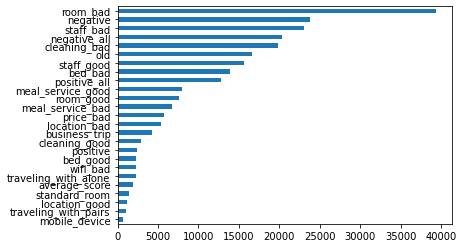

In [317]:
from sklearn.feature_selection import chi2 

# категориальные признаки
cat_cols = [
    'average_score', 'room_bad', 'room_good',
    'bed_good', 'bed_bad', 'cleaning_bad', 'cleaning_good', 'wifi_bad', 
    'staff_bad', 'staff_good', 'meal_service_bad', 'meal_service_good', 
    'location_bad', 'location_good', 'old', 'price_bad', 
    'negative_all','positive_all', 'negative', 'positive',  
    'business_trip',  'traveling_with_alone',
    'traveling_with_pairs', 'standard_room', 'mobile_device'
]

y = y.astype('int')
# Проанализируем важность категориальных признаков
imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh');

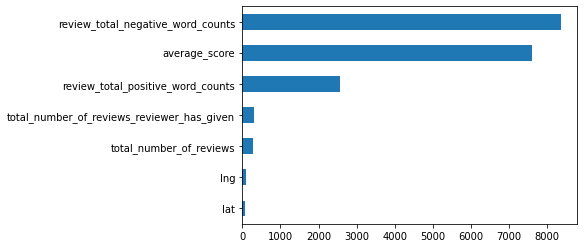

In [318]:
from sklearn.feature_selection import f_classif # anova

# Непрерывные признаки
num_cols = [
    'total_number_of_reviews', 'review_total_negative_word_counts', 'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given', 'average_score', 'lat', 'lng'
]
# average_score проверила в категориальных признаках, так было написано в примере в юнете, а так же
# решила проверить в непрерывных, так как данное число должно постепенно меняться 

# Проанализируем важность непрерывных признаков
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh');

In [319]:
# Уберем малозначимые признаки
data_copy.drop(['total_number_of_reviews', 'total_number_of_reviews_reviewer_has_given', 'lat', 'lng'
          ], axis=1, inplace=True)

In [320]:
data = data_copy

# 7. Построение модели 

<AxesSubplot:>

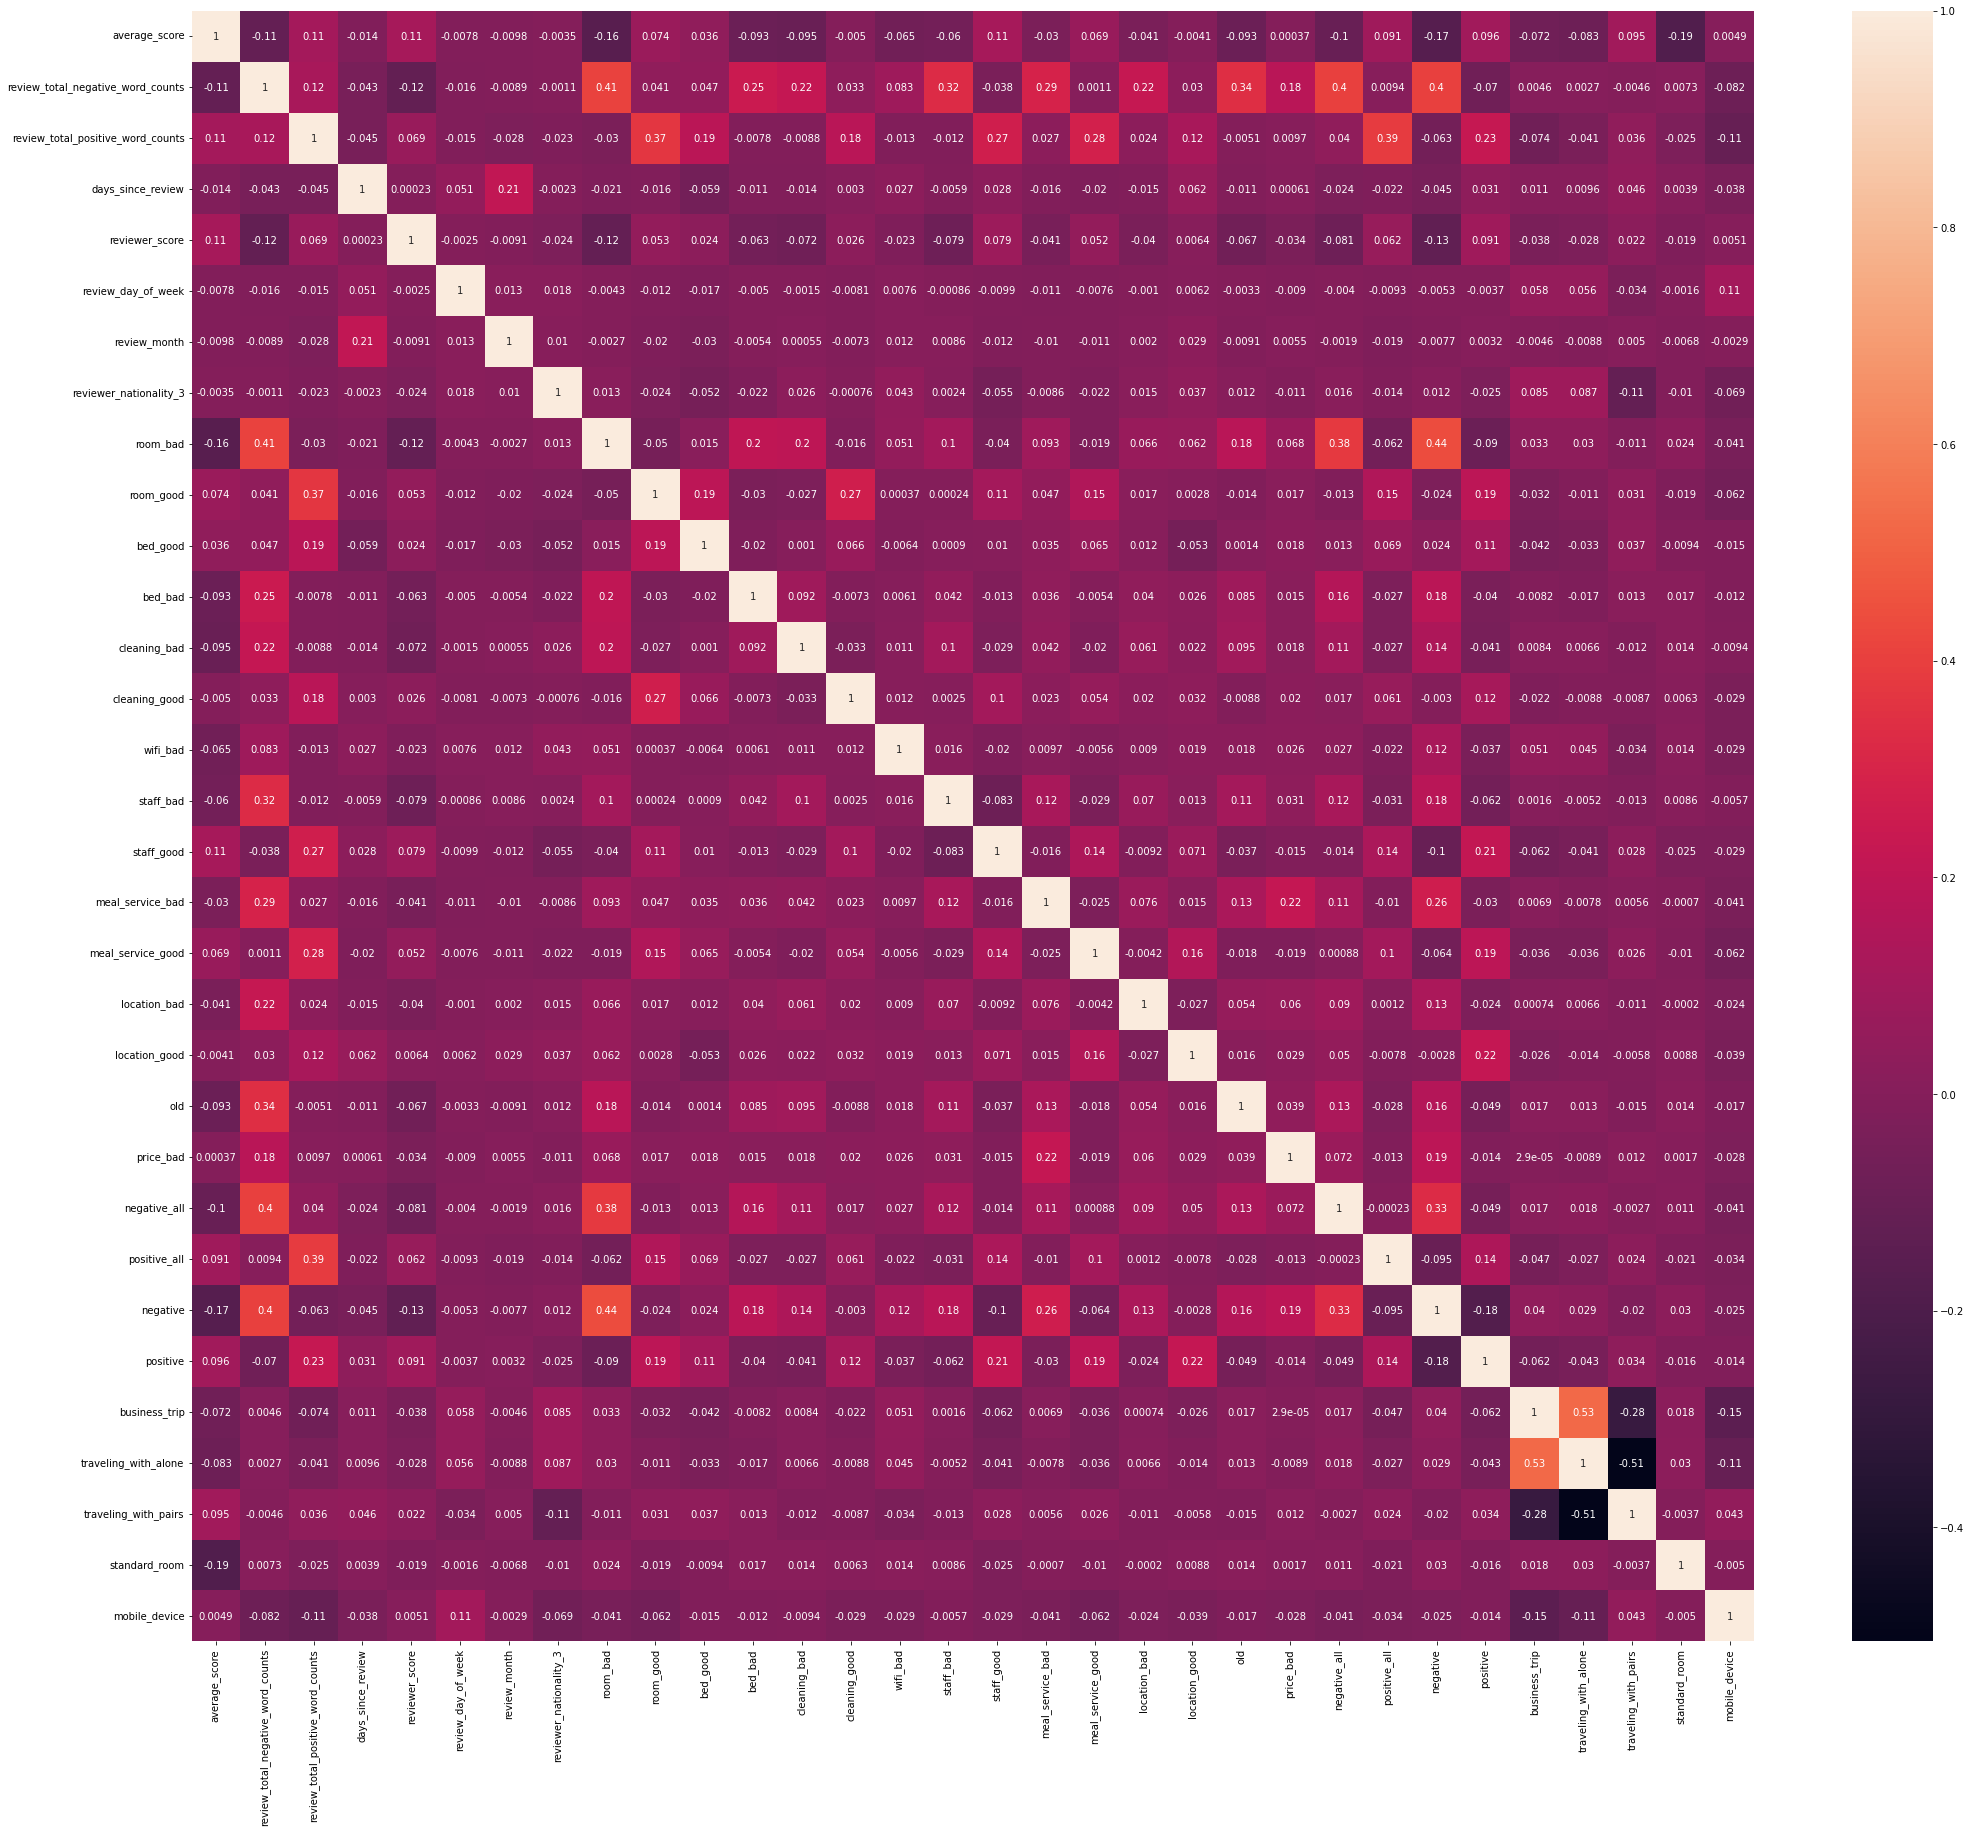

In [321]:
plt.rcParams['figure.figsize'] = (35,30)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

In [322]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 33 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   average_score                      515431 non-null  float64
 1   review_total_negative_word_counts  515431 non-null  float64
 2   review_total_positive_word_counts  515431 non-null  float64
 3   days_since_review                  515431 non-null  float64
 4   sample                             515431 non-null  int64  
 5   reviewer_score                     515431 non-null  float64
 6   review_day_of_week                 515431 non-null  int64  
 7   review_month                       515431 non-null  int64  
 8   reviewer_nationality_3             515431 non-null  int64  
 9   room_bad                           515431 non-null  int64  
 10  room_good                          515431 non-null  int64  
 11  bed_good                           5154

In [323]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [324]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [325]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 32), (386496, 32), (386496, 31), (309196, 31), (77300, 31))

In [326]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [327]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [328]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   47.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.7s finished


In [329]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 0.8840198723382409


<AxesSubplot:>

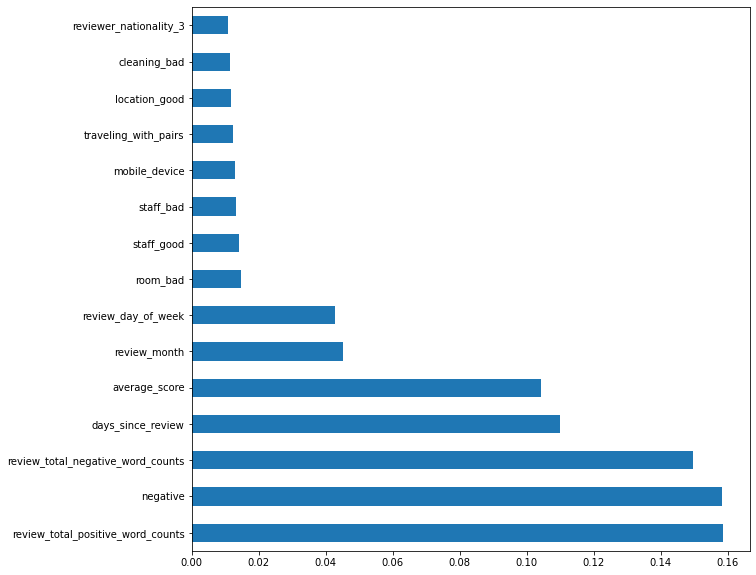

In [330]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [331]:
test_data.sample(10)

,average_score,review_total_negative_word_counts,review_total_positive_word_counts,days_since_review,reviewer_score,review_day_of_week,review_month,reviewer_nationality_3,room_bad,room_good,...,price_bad,negative_all,positive_all,negative,positive,business_trip,traveling_with_alone,traveling_with_pairs,standard_room,mobile_device
78277,7.1,0.047619,-0.411765,0.541096,0.0,0,7,0,1,1,...,0,0,0,1,1,1,1,0,0,0
74734,9.3,0.523810,0.588235,0.071233,0.0,0,6,0,0,1,...,0,0,1,1,1,0,0,1,1,1
43798,9.5,0.333333,0.235294,0.494521,0.0,6,8,0,0,1,...,0,0,1,1,1,0,0,0,0,1
17954,8.0,0.000000,0.823529,0.606849,0.0,1,5,0,0,0,...,0,0,1,1,1,0,0,0,0,1
44015,8.3,0.380952,0.000000,0.323288,0.0,5,12,0,1,1,...,0,0,0,1,1,1,0,1,0,0
44036,7.8,1.047619,0.470588,0.109589,0.0,0,5,0,1,0,...,0,0,1,1,1,0,0,0,0,1
21197,8.2,-0.428571,1.058824,0.501370,0.0,1,8,1,0,0,...,0,0,0,0,1,0,0,1,0,0
10553,9.4,-0.428571,-0.411765,0.476712,0.0,5,8,0,0,0,...,0,0,0,0,1,0,0,0,0,1
46708,8.9,-0.428571,0.058824,0.758904,0.0,2,1,0,0,0,...,0,0,0,0,1,0,0,1,1,0
107460,8.9,-0.428571,-0.176471,0.652055,0.0,3,4,1,0,0,...,0,0,0,0,1,0,0,0,0,0


In [332]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [333]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [334]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.8s finished


In [335]:
predict_submission

array([8.589, 7.764, 8.172, ..., 8.185, 9.452, 6.634])

In [336]:
list(sample_submission)

['reviewer_score', 'id']

In [337]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.589,488440
1,7.764,274649
2,8.172,374688
3,9.584,404352
4,9.474,451596
5,7.906,302161
6,7.724,317079
7,7.435,13963
8,8.969,159785
9,7.689,195089
